In [ ]:
!pip install hmmlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 75;
num_models = 8;
df = pd.read_csv('/content/SPY.csv')

In [ ]:
Volatility = []

# MA is the 10 day SMA
MA = []

# Return is the single-day percentage return
Return = []
ma_sum = 0;

# Warming up data for moving average and volatility calculations
for i in range (0, 10):
    Volatility.append(0);
    MA.append(0);
    Return.append(0);
    ma_sum += df['Close'][i];

# Filling in data for return, moving average, and volatility
for ind in df.index:
    if ind >= 10:
        tail_close = df['Close'][ind-10];
        prev_close = df['Close'][ind-1];
        head_close = df['Close'][ind];
        ma_sum = (ma_sum - tail_close + head_close);
        ma_curr = ma_sum/10;
        MA.append(ma_curr);
        Return.append(((head_close-prev_close)/prev_close)*100);
        #Computing Volatility
        vol_sum = 0;
        for i in range (0,10):
            curr_vol = abs(ma_curr - df['Close'][ind-i]);
            vol_sum += (curr_vol ** 2);
        Volatility.append(vol_sum/10);

In [ ]:
# Adding columns to dataframe
df['Volatility'] = Volatility;
df['MA'] = MA;
df['Return'] = Return;
# Dataframe readjustment
total_length = 6843
drop_length = 3508
training_length = 2706
test_length = total_length - drop_length - training_length
data_length = training_length+test_length
df = df.drop(range(0, drop_length));
df.index = range(0, data_length);
# Creating testing and training dataset
# 2000 datapoints in training, 838 datapoints in test
test = pd.DataFrame(df, index = range(training_length, data_length))
test.index = range(0,test_length)
training = df.drop(range(training_length, data_length))

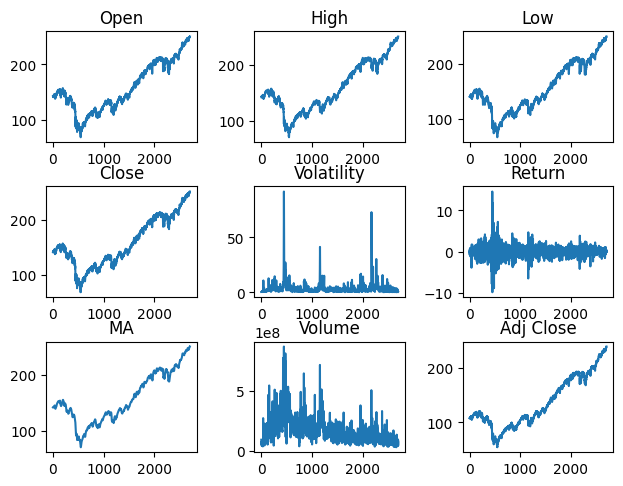

In [ ]:
fig, a =  plt.subplots(3,3)
x = np.arange(1,5)
fig.tight_layout()
a[0][0].plot(range(0,training_length), training.iloc[:,1])
a[0][0].set_title('Open')
a[0][1].plot(range(0,training_length), training.iloc[:,2])
a[0][1].set_title('High')
a[0][2].plot(range(0,training_length), training.iloc[:,3])
a[0][2].set_title('Low')
a[1][0].plot(range(0,training_length), training.iloc[:,4])
a[1][0].set_title('Close')
a[1][1].plot(range(0,training_length), training.iloc[:,7])
a[1][1].set_title('Volatility')
a[1][2].plot(range(0,training_length), training.iloc[:,9])
a[1][2].set_title('Return')
a[2][0].plot(range(0,training_length), training.iloc[:,8])
a[2][0].set_title('MA')
a[2][1].plot(range(0,training_length), training.iloc[:,6])
a[2][1].set_title('Volume')
a[2][2].plot(range(0,training_length), training.iloc[:,5])
a[2][2].set_title('Adj Close')
plt.show()

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Volatility,MA,Return
0,2007-01-03,142.250000,142.860001,140.570007,141.369995,107.832581,94807600,0.238721,141.796999,-0.176529
1,2007-01-04,141.229996,142.050003,140.610001,141.669998,108.061440,69620600,0.237210,141.768999,0.212211
2,2007-01-05,141.330002,141.399994,140.380005,140.539993,107.199524,76645300,0.339690,141.600998,-0.797632
3,2007-01-08,140.820007,141.410004,140.250000,141.190002,107.695328,71655000,0.318505,141.505998,0.462508
4,2007-01-09,141.309998,141.600006,140.399994,141.070007,107.603760,75680100,0.333190,141.450999,-0.084988


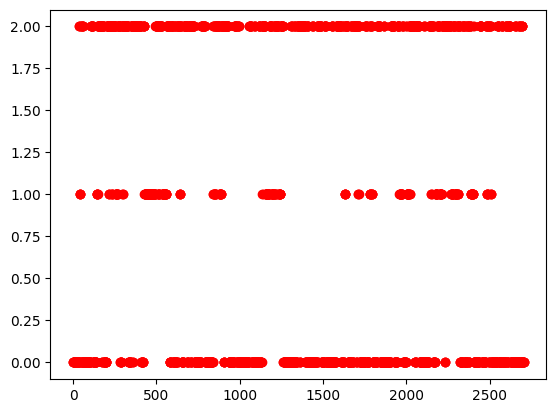

In [ ]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations);
vol = training.iloc[:,7];
ret = training.iloc[:,9];
obs = [];
for i in range(0, len(vol)):
    arr = [];
    arr.append(vol[i]);
    arr.append(ret[i]);
    obs.append(arr);

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)
plt.plot(predictions, 'ro');

In [ ]:
regime_vol = [];
regime_ret = [];
regime_count = [];
return_map = {};

for i in range(0, hidden_states):
    regime_vol.append(0);
    regime_ret.append(0);
    regime_count.append(0);

for i in range(0, len(predictions)):
    regime_count[predictions[i]] += 1;
    regime_vol[predictions[i]] += training.iloc[i, 7];
    regime_ret[predictions[i]] += training.iloc[i, 9];

    if not predictions[i] in return_map:
        return_map[predictions[i]] = [];
    return_map[predictions[i]].append(training.iloc[i,9]);

for i in range(0, hidden_states):
    regime_vol[i] = regime_vol[i] / regime_count[i];
    regime_ret[i] = regime_ret[i] / regime_count[i];
max_occurrence = np.argmax(regime_count)
for i in range(0, hidden_states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol[i]));
    print("Avg Return: {0}".format(regime_ret[i]));
    print("Occurrence: {0}\n".format(regime_count[i]));

Regime 0
Avg Vol: 0.9438078388265714
Avg Return: 0.04635054516906783
Occurrence: 1221

Regime 1
Avg Vol: 13.63465684440595
Avg Return: -0.06600020310820759
Occurrence: 345

Regime 2
Avg Vol: 3.473911201667222
Avg Return: 0.03984471599660957
Occurrence: 1140



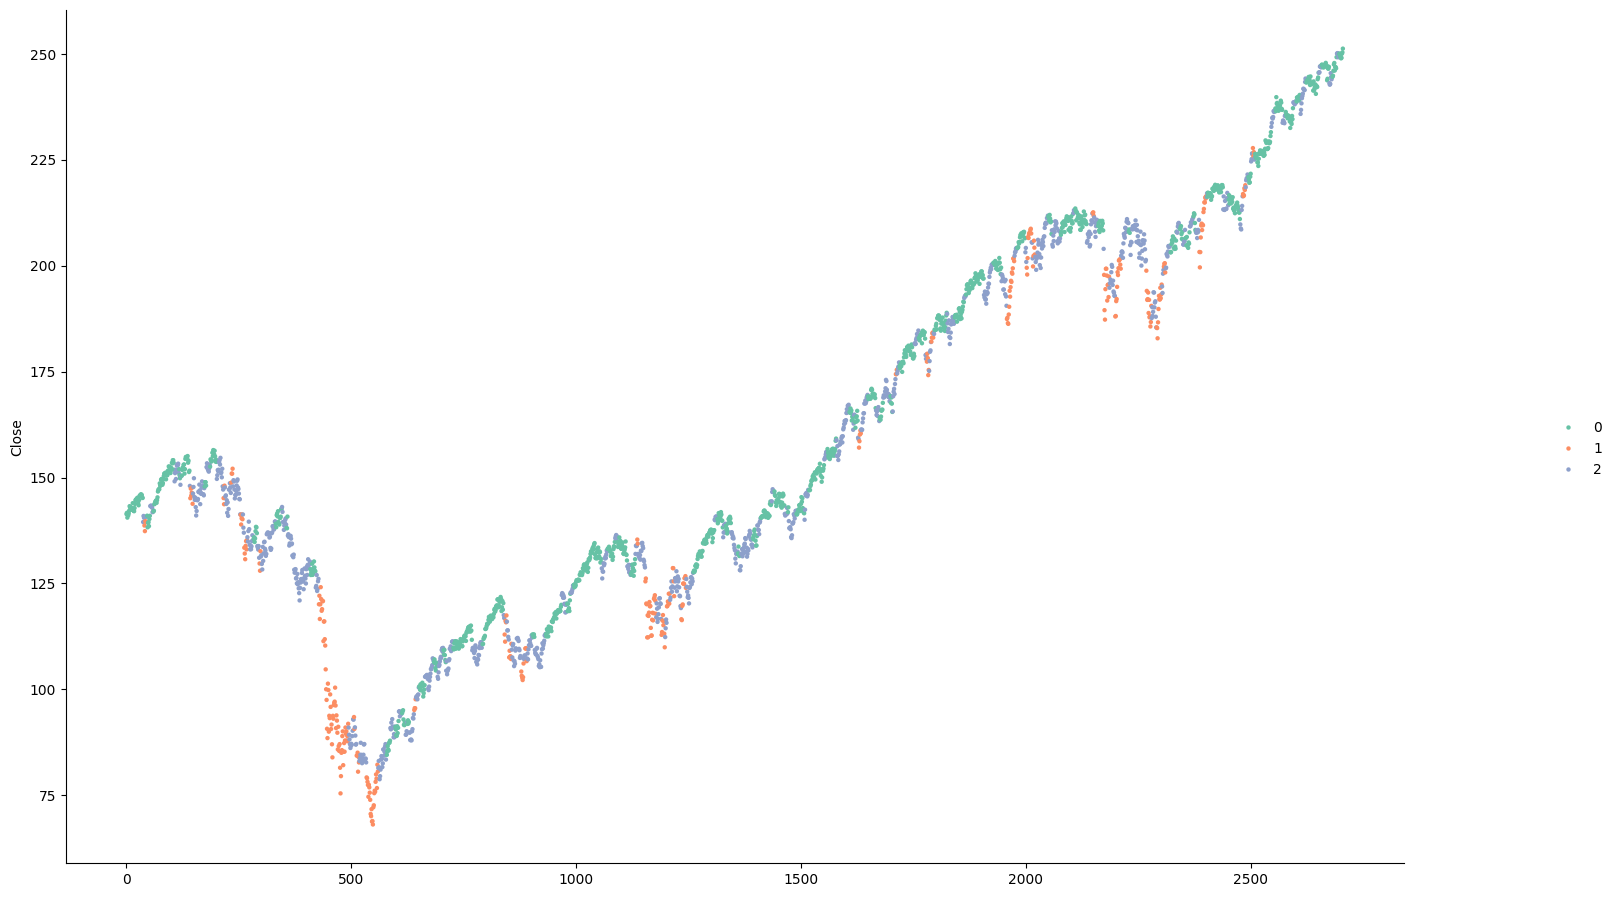

In [ ]:
plot = sns.relplot(x=range(0,training_length), y="Close", data=training, hue=predictions,
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

In [ ]:
returns = pd.DataFrame(data = return_map[max_occurrence])
for i in range(0, hidden_states):
    if(i is not max_occurrence):
        returns[i] = pd.Series(return_map[i]);

#sns.pairplot(data = returns, height=3);
distribution = model.get_stationary_distribution();
for i in range(0, hidden_states):
    print("Regime {0}: {1}".format(i, distribution[i]));

Regime 0: 0.44625114190253445
Regime 1: 0.13002355202777482
Regime 2: 0.4237253060696907


In [ ]:
import math
print("Model Score: {0}".format(abs(model.score(obs))));

Model Score: 8662.975071320609


In [ ]:
# Define labels for each regime based on characteristics
regime_labels = {0: "Low Volatility - Stable", 1: "Moderate Volatility - Caution", 2: "High Volatility - Risky"}

# Predict the next regime after the latest observation in the training data
latest_volatility = training.iloc[-1]['Volatility']
latest_return = training.iloc[-1]['Return']
latest_observation = np.array([[latest_volatility, latest_return]])

# Get the predicted regime for the next day
next_regime = model.predict(latest_observation)[0]
labeled_regime = regime_labels.get(next_regime, "Unknown Regime")
print(f"The predicted next regime is: {next_regime} - {labeled_regime}")

The predicted next regime is: 0 - Low Volatility - Stable


In [ ]:
training['Predicted Regime'] = predictions

# Now you can proceed to create the pseudo-labels based on volatility
# Define volatility threshold for high/low volatility
volatility_threshold = training['Volatility'].mean()  # Custom threshold can be set based on domain knowledge

# Generate pseudo-labels for high and low volatility based on threshold
training['Volatility_Label'] = training['Volatility'].apply(lambda x: 1 if x > volatility_threshold else 0)

# Calculate average volatility for each predicted regime
regime_volatility = {regime: np.mean(training[training['Predicted Regime'] == regime]['Volatility']) for regime in range(hidden_states)}
predicted_labels = [1 if regime_volatility[regime] > volatility_threshold else 0 for regime in predictions]

# Calculate "accuracy percentage" by comparing pseudo-labels with predicted labels
pseudo_accuracy_percentage = np.mean(training['Volatility_Label'].values == predicted_labels) * 100
print(f"Pseudo-accuracy percentage based on volatility alignment: {pseudo_accuracy_percentage:.2f}%")

Pseudo-accuracy percentage based on volatility alignment: 82.89%
